## Setup

<font color='red'>**Warning**: if you work on Colab, upload the data zip on Google Drive in order to not have to upload it on your environment every time. It's also much faster to upload files on Google Drive than on Colab.</font>

## Create dataset from directory

In [10]:
import tensorflow as tf
from pathlib import Path

IMG_WIDTH = IMG_HEIGHT = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/train'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/val'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

test_ds = tf.keras.utils.image_dataset_from_directory(
  Path('chest_xray/test'),
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=64,
  class_names=['normal', 'pneumonia'],
  label_mode='binary',
  color_mode='grayscale',
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


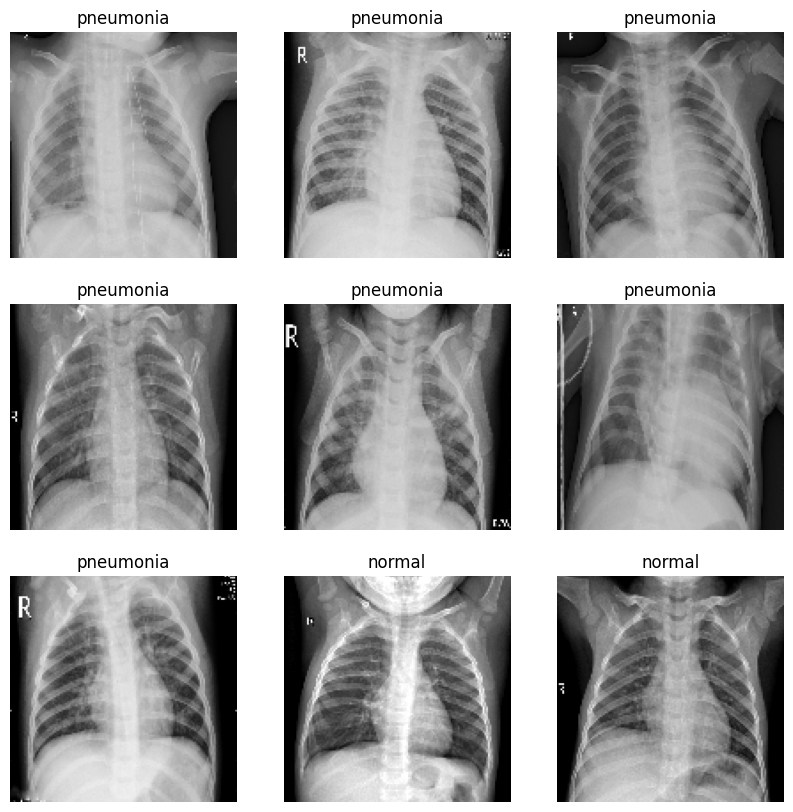

In [11]:
import matplotlib.pyplot as plt

# Extract a batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'{train_ds.class_names[int(labels[i])]}')
        plt.axis('off')

    plt.show()

## Compute class weights

In [12]:
import numpy as np

# Initialize class counts
class_counts = np.zeros(len(train_ds.class_names), dtype=np.int64)

# Iterate over the dataset to count samples in each class
for images, labels in train_ds:
    flattened_labels = tf.cast(labels, dtype=tf.int64)  # Cast labels to int64
    flattened_labels = tf.reshape(flattened_labels, [-1])  # Flatten the labels
    class_counts += np.bincount(flattened_labels.numpy(), minlength=len(train_ds.class_names))

# Compute total number of samples
total_samples = np.sum(class_counts)

# Compute class weights
num_classes = len(train_ds.class_names)
class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(class_counts)}

In [ ]:
class_weights

## Create CNN model

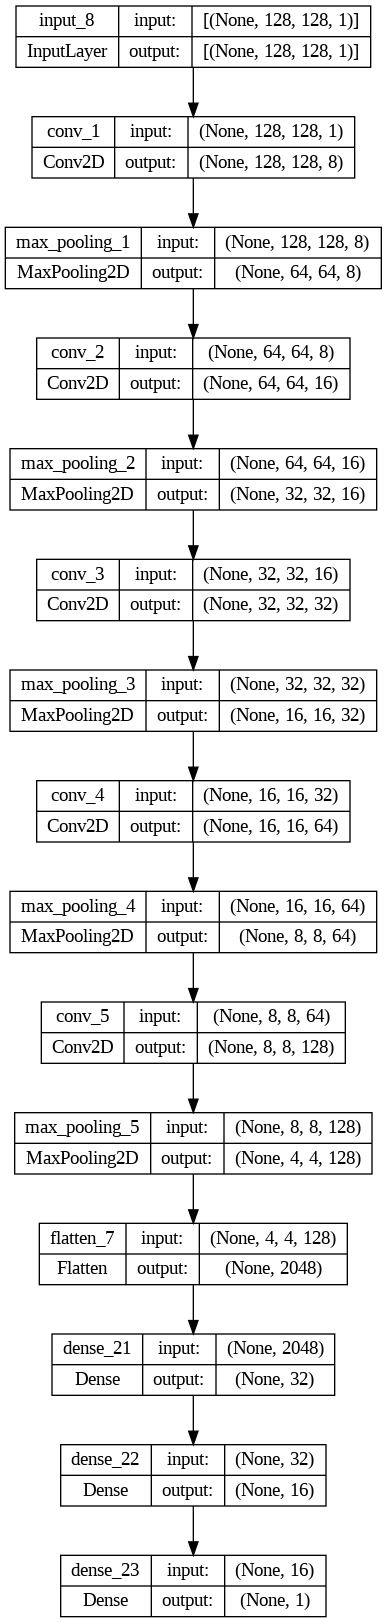

In [14]:
from keras.src.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import (
    layers,
    activations,
    Model,
    optimizers,
    losses,
)

# Define CNN model
input = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1), name='input_8')

# TODO: Complete this in order to have the same architecture
# as the one represented in the cell above
# note: use convolutions with relu and kernel size of 3.
conv_1 = Conv2D(8, (3, 3), padding='same', activation='relu', name='conv_1')(input)
max_poolling_1 = MaxPooling2D(pool_size=(2, 2), name='max_poolling_1')(conv_1)
conv_2 = Conv2D(16, (3, 3), padding='same', activation='relu', name='conv_2')(max_poolling_1)
max_poolling_2 = MaxPooling2D(pool_size=(2, 2), name='max_poolling_2')(conv_2)
conv_3 = Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_3')(max_poolling_2)
max_poolling_3 = MaxPooling2D(pool_size=(2, 2), name='max_poolling_3')(conv_3)
conv_4 = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_4')(max_poolling_3)
max_poolling_4 = MaxPooling2D(pool_size=(2, 2), name='max_poolling_4')(conv_4)
conv_5 = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv_5')(max_poolling_4)
max_poolling_5 = MaxPooling2D(pool_size=(2, 2), name='max_poolling_5')(conv_5)
flatten_7 = Flatten(name='flatten_7')(max_poolling_5)
dense_21 = Dense(32, activation='relu', name='dense_21')(flatten_7)
dense_22 = Dense(16, activation='relu', name='dense_22')(dense_21)
cnn_output = Dense(1, activation='sigmoid', name='dense_23')(dense_22)

cnn = Model(inputs=input, outputs=cnn_output)

# Compile CNN model
cnn.compile(optimizer=optimizers.AdamW(0.001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

In [15]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(cnn, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [16]:
history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights
)

82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 1.0000 - loss: 1.7189e-05 - val_accuracy: 0.9375 - val_loss: 0.0627
Epoch 36/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 1.0000 - loss: 1.6136e-05 - val_accuracy: 0.9375 - val_loss: 0.0634
Epoch 37/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 1.0000 - loss: 1.4987e-05 - val_accuracy: 0.9375 - val_loss: 0.0637
Epoch 38/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 1.0000 - loss: 1.4226e-05 - val_accuracy: 1.0000 - val_loss: 0.0608
Epoch 39/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 1.0000 - loss: 1.3166e-05 - val_accuracy: 1.0000 - val_loss: 0.0588
Epoch 40/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 1.0000 - loss: 1.2713e-05 - val_accuracy: 1.0000 - val_loss: 0.0602
Epoch 41/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 1.0000 - loss: 1.1441e-05 - val_accuracy: 1.0000 - val_loss: 0.0585
Epoch 42/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 1.0000 - loss: 1.0417e-0

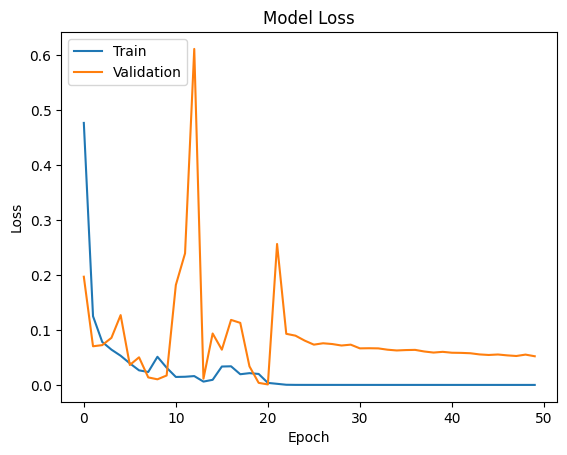

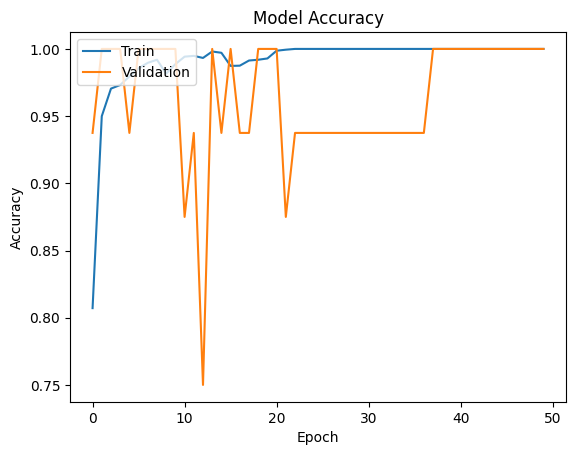

Test score (loss): 3.1901307106018066
Test accuracy: 0.7612179517745972


In [17]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

score = cnn.evaluate(test_ds, verbose=0)
print('Test score (loss):', score[0])
print('Test accuracy:', score[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


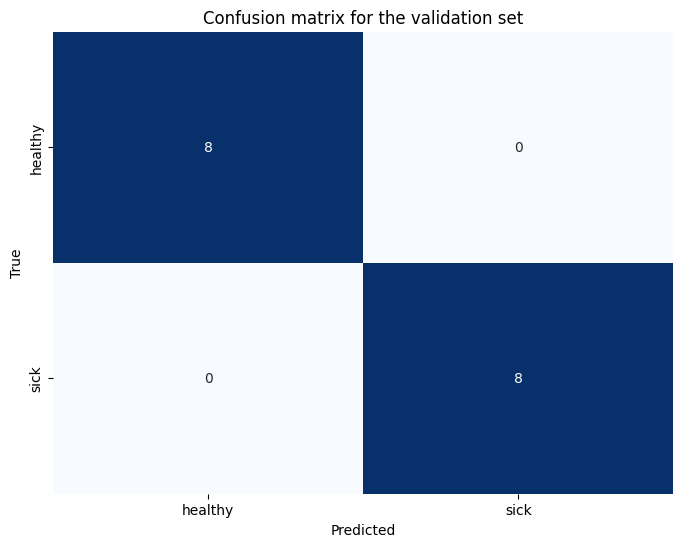

In [19]:
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

val_images = []
val_labels = []

for img, label in val_ds:
  val_images.append(img)
  val_labels.append(label)

val_images = np.vstack(val_images)
val_labels = np.vstack(val_labels).squeeze().astype(int)

# TODO: create confusion matrix and compute metrics here

pred = cnn.predict(val_images)
for i in range(len(pred)):
    pred[i] = 0 if pred[i][0] < 0.5 else 1
matrix = confusion_matrix(val_labels, pred)

pl.figure(figsize=(8, 6))
sns.heatmap(matrix.astype(int), annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["healthy", "sick"], yticklabels=["healthy", "sick"])
pl.title("Confusion matrix for the validation set")
pl.xlabel('Predicted')
pl.ylabel('True')
pl.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


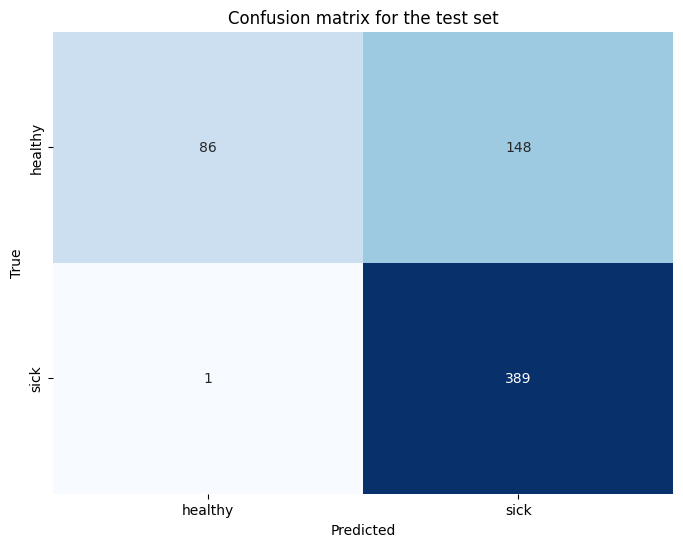

In [20]:
# and do the same for test set
test_images = []
test_labels =[]

for img, label in test_ds:
  test_images.append(img)
  test_labels.append(label)
  
test_images = np.vstack(test_images)
test_labels = np.vstack(test_labels).squeeze().astype(int)

pred = cnn.predict(test_images)
for i in range(len(pred)):
    pred[i] = 0 if pred[i][0] < 0.5 else 1
matrix = confusion_matrix(test_labels, pred)

pl.figure(figsize=(8, 6))
sns.heatmap(matrix.astype(int), annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["healthy", "sick"], yticklabels=["healthy", "sick"])
pl.title("Confusion matrix for the test set")
pl.xlabel('Predicted')
pl.ylabel('True')
pl.show()